# <a id='toc1_'></a>[Natural Language Processing with Disaster Tweets - ModernBERT](#toc0_)

Notebook for the Kaggle competition $\textit{Natural Language Processing with Disaster Tweets}$. Data consists of geolocated tweets, with a binary label indicating whether whether they're discussing a disaster.

In this notebook we perform minimal pre-processing and then fine-tune $\textit{ModernBERT}$, the latest encoder-only model of the BERT family. Results outperform traditional embedding+prediction pipelines explored in the notebook $\textit{Natural Language Processing with Disaster Tweets}$. 

**Table of contents**<a id='toc0_'></a>    
- [Natural Language Processing with Disaster Tweets - ModernBERT](#toc1_)    
  - [Data loading](#toc1_1_)    
  - [Minimal preprocessing](#toc1_2_)    
  - [Preprocessed data loading](#toc1_3_)    
  - [From Hugging Face](#toc1_4_)    
  - [Fine tune ModernBERT](#toc1_5_)    
  - [Evaluation and prediction](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Data loading](#toc0_)

In [16]:
SUBMISSION_PATH = "submissions/"
MODEL_PATH = "models/"
DATA_PATH = "nlp_data/"

In [17]:
!pip install langdetect

import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
import langdetect
from tqdm import tqdm
import pickle

In [ ]:
# List files
DATA_PATH = "nlp_data/"
print(os.listdir(DATA_PATH))

# Read data
df_train = pd.read_csv(f"{DATA_PATH}train.csv")
print(df_train.info())
df_test = pd.read_csv(f"{DATA_PATH}test.csv")
print(df_test.info())

# Remove the id column
df_train = df_train.drop(columns=["id"])
test_ids = df_test["id"]
df_test = df_test.drop(columns=["id"])

# Remove the target column
df_train_x = df_train.drop(columns=["target"])
df_train_y = df_train["target"]
df_test_x = df_test

# Fill all missing values with empty string
for df in [df_train_x,df_test_x]:
    for col in df.columns:
        df[col] = df[col].fillna("")
        df[col] = df[col].astype(str)
    print(df.info())
    display(df.sample(5))

['.ipynb_checkpoints', 'minimal_preproc_data.pkl', 'train.csv', 'sample_submission.csv', 'test.csv']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data 

,keyword,location,text
4354,hijacker,,Governor Allows Parole for School Bus Hijacker...
586,bioterror,Memphis,FedEx not willing to transport research specim...
6792,tragedy,,Rly tragedy in MP: Some live to recount horror...
5630,refugees,Warri,Cameroon Repatriated 12000 Nigerian Refugees h...
4056,forest%20fires,"Boise, Idaho",8-5-2015 - 4:30 P.M. - Progress Being Made on ...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   3263 non-null   object
 1   location  3263 non-null   object
 2   text      3263 non-null   object
dtypes: object(3)
memory usage: 76.6+ KB
None


,keyword,location,text
765,collision,,Call to car vs fed ex truck head on collision ...
948,debris,,With authorities ???increasingly confident??? ...
696,cliff%20fall,,I might go losing it n drive off a cliff fall ...
2337,quarantine,Italy,New post: 'Reddit Will Now Quarantine Offensiv...
1628,flames,New York,*NEW* Snap On Tools Black baseball Hat/Cap Sil...


## <a id='toc1_2_'></a>[Minimal preprocessing](#toc0_)

We perform minimal preprocessing to prepare data before passing it to the tokenizer, and, subsequently, to the model. We detect the tweet's language, translate the text when necessary and remove non alphabetic characters.

In [13]:
!pip install deep_translator

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from deep_translator import GoogleTranslator
import urllib
import pickle
from tqdm import tqdm
tqdm.pandas()

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

import nltk.data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [17]:
class PreprocessingPipeline:

    def __init__(self):
        self.punctuation = string.punctuation

    # Translate into english
    def translate(self, text):
        # Detect language
        try:
            lang = langdetect.detect(text)
        except Exception as e:
            print(f"Language detection error: {e}")
            return text

        # Translate to English if not already in English
        if lang != 'en':
            try:
                return GoogleTranslator(source=lang, target='en').translate(text)
            except Exception as e:
                print(f"Translation error: {e}")
                return ""
        else:
            return text

    #Converting text into tokens
    def tokenize(self, text):
        return word_tokenize(text)

    #Converting the tokens to lowercase
    def case_fold(self, token):
        return token.lower()

    #Removing unwanted characters
    def remove_unwanted_characters(self, token):
        if token is not None and not token.isalpha():
            return None
        return token

    #Preprocessing text by applying all steps from above
    def preprocess_text(self, text):
        """Returns a list of preprocessed tokens from the input text."""
        if not text:
            return ""
        if not isinstance(text,str):
            return ""
        text = self.translate(text)
        tokens = self.tokenize(text)
        preprocessed_tokens = []
        for token in tokens:
            token = self.case_fold(token)
            token = self.remove_unwanted_characters(token)
            if token is not None:
                preprocessed_tokens.append(token)

        return " ".join(preprocessed_tokens)

In [18]:
# Example of a non english text
preprocessor = PreprocessingPipeline()
text_ = "Il solito cassetto della miseria...§!!!##$%&/()=?"
text_ = preprocessor.preprocess_text(text_)
print(text_)

the usual drawer of misery


In [19]:
# Apply preprocessor
for df in [df_train_x, df_test_x]:
  for col in df.columns:
    df[col] = df[col].progress_apply(preprocessor.preprocess_text)

display(df_train_x.sample(5))

 68%|██████▊   | 5204/7613 [05:38<02:50, 14.10it/s]

Translation error: obliterated --> No translation was found using the current translator. Try another translator?


  1%|▏         | 105/7613 [00:20<14:17,  8.76it/s]

Language detection error: No features in text.
Language detection error: No features in text.


  2%|▏         | 115/7613 [00:20<11:42, 10.67it/s]

Language detection error: No features in text.
Language detection error: No features in text.


  2%|▏         | 123/7613 [00:22<22:18,  5.60it/s]

Language detection error: No features in text.
Language detection error: No features in text.


  2%|▏         | 129/7613 [00:22<14:59,  8.32it/s]

Language detection error: No features in text.
Language detection error: No features in text.
Language detection error: No features in text.
Language detection error: No features in text.


  2%|▏         | 167/7613 [00:30<28:01,  4.43it/s]

Language detection error: No features in text.


  5%|▍         | 377/7613 [01:00<09:03, 13.32it/s]

Language detection error: No features in text.


  5%|▌         | 397/7613 [01:08<52:37,  2.29it/s]

Language detection error: No features in text.


  5%|▌         | 417/7613 [01:12<27:11,  4.41it/s]

Language detection error: No features in text.


  7%|▋         | 516/7613 [01:28<23:06,  5.12it/s]

Language detection error: No features in text.


  9%|▊         | 662/7613 [01:44<09:29, 12.20it/s]

Language detection error: No features in text.


 10%|▉         | 759/7613 [01:59<09:17, 12.29it/s]

Language detection error: No features in text.


 11%|█         | 842/7613 [02:13<04:24, 25.58it/s]

Language detection error: No features in text.


 12%|█▏        | 876/7613 [02:15<07:00, 16.02it/s]

Language detection error: No features in text.


 12%|█▏        | 896/7613 [02:23<33:54,  3.30it/s]

Language detection error: No features in text.


 13%|█▎        | 998/7613 [02:42<07:07, 15.46it/s]

Language detection error: No features in text.


 13%|█▎        | 1005/7613 [02:42<06:56, 15.86it/s]

Language detection error: No features in text.


 14%|█▎        | 1038/7613 [02:47<10:39, 10.28it/s]

Language detection error: No features in text.


 15%|█▍        | 1105/7613 [02:53<06:50, 15.87it/s]

Language detection error: No features in text.


 16%|█▌        | 1201/7613 [03:03<04:33, 23.42it/s]

Language detection error: No features in text.


 17%|█▋        | 1285/7613 [03:20<15:25,  6.83it/s]

Language detection error: No features in text.


 17%|█▋        | 1297/7613 [03:20<09:07, 11.53it/s]

Language detection error: No features in text.


 17%|█▋        | 1332/7613 [03:25<07:44, 13.53it/s]

Language detection error: No features in text.


 19%|█▉        | 1473/7613 [03:45<09:30, 10.77it/s]

Language detection error: No features in text.


 20%|██        | 1540/7613 [03:52<09:35, 10.56it/s]

Language detection error: No features in text.


 21%|██        | 1591/7613 [04:04<12:24,  8.09it/s]

Language detection error: No features in text.


 22%|██▏       | 1710/7613 [04:23<08:37, 11.41it/s]

Language detection error: No features in text.


 24%|██▎       | 1796/7613 [04:34<06:04, 15.96it/s]

Language detection error: No features in text.


 24%|██▍       | 1821/7613 [04:36<06:41, 14.42it/s]

Language detection error: No features in text.


 24%|██▍       | 1864/7613 [04:45<15:40,  6.11it/s]

Language detection error: No features in text.


 25%|██▍       | 1878/7613 [04:48<14:06,  6.77it/s]

Language detection error: No features in text.


 25%|██▌       | 1936/7613 [04:56<20:05,  4.71it/s]

Language detection error: No features in text.


 26%|██▌       | 1998/7613 [05:05<10:00,  9.36it/s]

Language detection error: No features in text.


 26%|██▋       | 2003/7613 [05:06<10:14,  9.13it/s]

Language detection error: No features in text.


 27%|██▋       | 2057/7613 [05:14<11:02,  8.39it/s]

Language detection error: No features in text.


 29%|██▊       | 2178/7613 [05:40<07:22, 12.28it/s]

Language detection error: No features in text.


 29%|██▉       | 2217/7613 [05:42<05:32, 16.23it/s]

Language detection error: No features in text.


 31%|███       | 2323/7613 [05:58<09:23,  9.39it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 31%|███       | 2341/7613 [06:00<08:16, 10.62it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 33%|███▎      | 2534/7613 [06:19<11:03,  7.65it/s]

Language detection error: No features in text.


 33%|███▎      | 2541/7613 [06:21<12:30,  6.76it/s]

Language detection error: No features in text.


 34%|███▍      | 2591/7613 [06:26<06:03, 13.80it/s]

Language detection error: No features in text.


 35%|███▍      | 2635/7613 [06:32<10:42,  7.74it/s]

Language detection error: No features in text.


 36%|███▋      | 2760/7613 [06:47<07:36, 10.63it/s]

Language detection error: No features in text.


 37%|███▋      | 2836/7613 [06:57<05:27, 14.61it/s]

Language detection error: No features in text.


 38%|███▊      | 2882/7613 [07:04<09:59,  7.89it/s]

Language detection error: No features in text.


 39%|███▉      | 2956/7613 [07:15<06:57, 11.15it/s]

Language detection error: No features in text.


 41%|████      | 3121/7613 [07:43<05:28, 13.68it/s]

Language detection error: No features in text.


 42%|████▏     | 3235/7613 [08:03<08:15,  8.84it/s]

Language detection error: No features in text.


 44%|████▎     | 3322/7613 [08:15<13:50,  5.17it/s]

Language detection error: No features in text.


 44%|████▎     | 3324/7613 [08:15<14:12,  5.03it/s]

Language detection error: No features in text.


 45%|████▌     | 3458/7613 [08:35<08:36,  8.05it/s]

Language detection error: No features in text.


 47%|████▋     | 3565/7613 [08:42<02:58, 22.64it/s]

Language detection error: No features in text.


 47%|████▋     | 3603/7613 [08:47<09:33,  6.99it/s]

Language detection error: No features in text.


 48%|████▊     | 3676/7613 [08:54<06:19, 10.36it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 50%|█████     | 3843/7613 [09:19<09:20,  6.72it/s]

Language detection error: No features in text.


 52%|█████▏    | 3970/7613 [09:39<17:26,  3.48it/s]

Language detection error: No features in text.


 53%|█████▎    | 4008/7613 [09:44<06:48,  8.83it/s]

Language detection error: No features in text.


 53%|█████▎    | 4040/7613 [09:47<04:48, 12.38it/s]

Language detection error: No features in text.


 55%|█████▍    | 4153/7613 [10:03<06:17,  9.17it/s]

Language detection error: No features in text.


 56%|█████▌    | 4229/7613 [10:19<05:37, 10.03it/s]

Language detection error: No features in text.


 56%|█████▌    | 4241/7613 [10:19<03:59, 14.06it/s]

Language detection error: No features in text.


 57%|█████▋    | 4304/7613 [10:26<04:58, 11.07it/s]

Language detection error: No features in text.


 57%|█████▋    | 4317/7613 [10:27<04:42, 11.67it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 58%|█████▊    | 4438/7613 [10:38<03:05, 17.07it/s]

Language detection error: No features in text.


 59%|█████▉    | 4474/7613 [10:43<04:59, 10.48it/s]

Language detection error: No features in text.


 59%|█████▉    | 4516/7613 [10:46<02:46, 18.59it/s]

Language detection error: No features in text.


 60%|█████▉    | 4563/7613 [10:50<02:41, 18.91it/s]

Language detection error: No features in text.


 62%|██████▏   | 4725/7613 [11:11<02:35, 18.55it/s]

Language detection error: No features in text.


 66%|██████▌   | 5002/7613 [11:56<04:04, 10.67it/s]

Language detection error: No features in text.


 69%|██████▉   | 5290/7613 [12:42<03:48, 10.16it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 70%|███████   | 5339/7613 [12:51<03:47, 10.00it/s]

Language detection error: No features in text.


 71%|███████   | 5399/7613 [13:05<11:58,  3.08it/s]

Language detection error: No features in text.


 71%|███████   | 5404/7613 [13:07<15:48,  2.33it/s]

Language detection error: No features in text.


 71%|███████   | 5412/7613 [13:10<14:22,  2.55it/s]

Translation error: Request exception can happen due to an api connection error. Please check your connection and try again


 71%|███████   | 5416/7613 [13:12<15:08,  2.42it/s]

Translation error: Request exception can happen due to an api connection error. Please check your connection and try again


 74%|███████▍  | 5638/7613 [13:42<02:07, 15.46it/s]

Language detection error: No features in text.


 79%|███████▊  | 5977/7613 [14:32<06:22,  4.27it/s]

Language detection error: No features in text.


 79%|███████▉  | 6023/7613 [14:40<02:34, 10.26it/s]

Language detection error: No features in text.


 79%|███████▉  | 6038/7613 [14:41<02:07, 12.32it/s]

Language detection error: No features in text.


 81%|████████  | 6167/7613 [14:58<03:30,  6.88it/s]

Language detection error: No features in text.


 81%|████████  | 6172/7613 [14:59<04:58,  4.83it/s]

Language detection error: No features in text.


 82%|████████▏ | 6218/7613 [15:10<02:50,  8.17it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 83%|████████▎ | 6319/7613 [15:28<02:30,  8.59it/s]

Language detection error: No features in text.


 83%|████████▎ | 6328/7613 [15:29<01:43, 12.42it/s]

Language detection error: No features in text.


 84%|████████▍ | 6419/7613 [15:37<00:47, 25.31it/s]

Language detection error: No features in text.


 85%|████████▍ | 6460/7613 [15:41<02:06,  9.08it/s]

Language detection error: No features in text.


 86%|████████▌ | 6542/7613 [15:49<01:20, 13.27it/s]

Language detection error: No features in text.


 87%|████████▋ | 6656/7613 [16:00<01:24, 11.31it/s]

Language detection error: No features in text.


 88%|████████▊ | 6698/7613 [16:04<00:57, 15.90it/s]

Language detection error: No features in text.


 88%|████████▊ | 6726/7613 [16:07<01:41,  8.71it/s]

Language detection error: No features in text.


 89%|████████▉ | 6771/7613 [16:13<01:43,  8.17it/s]

Language detection error: No features in text.


 91%|█████████ | 6926/7613 [16:32<01:10,  9.78it/s]

Language detection error: No features in text.


 91%|█████████▏| 6963/7613 [16:34<00:33, 19.27it/s]

Language detection error: No features in text.


 94%|█████████▍| 7180/7613 [17:04<01:17,  5.57it/s]

Language detection error: No features in text.


 94%|█████████▍| 7189/7613 [17:05<01:09,  6.08it/s]

Language detection error: No features in text.


 95%|█████████▍| 7199/7613 [17:07<00:52,  7.95it/s]

Language detection error: No features in text.


 95%|█████████▌| 7241/7613 [17:14<01:01,  6.08it/s]

Language detection error: No features in text.


 95%|█████████▌| 7243/7613 [17:15<01:05,  5.62it/s]

Language detection error: No features in text.


 99%|█████████▊| 7502/7613 [17:52<00:14,  7.87it/s]

Language detection error: No features in text.


 99%|█████████▉| 7554/7613 [18:00<00:05, 10.30it/s]

Language detection error: No features in text.


  2%|▏         | 49/3263 [00:04<07:56,  6.74it/s]

Language detection error: No features in text.


  2%|▏         | 55/3263 [00:06<08:57,  5.97it/s]

Language detection error: No features in text.


  4%|▍         | 146/3263 [00:14<04:54, 10.59it/s]

Language detection error: No features in text.


 10%|█         | 337/3263 [00:38<11:22,  4.28it/s]

Language detection error: No features in text.


 14%|█▍        | 456/3263 [00:53<03:51, 12.13it/s]

Language detection error: No features in text.


 17%|█▋        | 551/3263 [01:08<05:44,  7.87it/s]

Language detection error: No features in text.


 17%|█▋        | 566/3263 [01:09<03:26, 13.04it/s]

Language detection error: No features in text.


 19%|█▉        | 615/3263 [01:15<03:08, 14.04it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 31%|███       | 1002/3263 [01:56<01:40, 22.55it/s]

Language detection error: No features in text.


 31%|███       | 1006/3263 [01:57<02:45, 13.63it/s]

Language detection error: No features in text.


 32%|███▏      | 1029/3263 [01:59<02:01, 18.33it/s]

Language detection error: No features in text.


 41%|████▏     | 1349/3263 [02:36<04:29,  7.11it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 46%|████▌     | 1493/3263 [02:52<05:49,  5.06it/s]

Language detection error: No features in text.


 48%|████▊     | 1565/3263 [03:01<03:34,  7.93it/s]

Language detection error: No features in text.


 56%|█████▌    | 1813/3263 [03:42<02:46,  8.73it/s]

Language detection error: No features in text.


 56%|█████▌    | 1823/3263 [03:45<06:14,  3.84it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 56%|█████▌    | 1831/3263 [03:46<03:09,  7.57it/s]

Language detection error: No features in text.


 57%|█████▋    | 1860/3263 [03:49<02:26,  9.61it/s]

Language detection error: No features in text.


 81%|████████  | 2635/3263 [05:36<01:23,  7.48it/s]

Language detection error: No features in text.


 81%|████████▏ | 2659/3263 [05:39<01:02,  9.68it/s]

Language detection error: No features in text.


 83%|████████▎ | 2714/3263 [05:49<01:12,  7.61it/s]

Language detection error: No features in text.


 86%|████████▌ | 2813/3263 [05:59<00:37, 12.13it/s]

Language detection error: No features in text.


 88%|████████▊ | 2858/3263 [06:03<00:37, 10.78it/s]

Language detection error: No features in text.


 89%|████████▉ | 2920/3263 [06:11<00:24, 13.93it/s]

Language detection error: No features in text.


 90%|████████▉ | 2936/3263 [06:13<00:41,  7.96it/s]

Language detection error: No features in text.


 91%|█████████▏| 2983/3263 [06:18<00:26, 10.64it/s]

Language detection error: No features in text.


 92%|█████████▏| 3013/3263 [06:22<00:25,  9.96it/s]

Language detection error: No features in text.


 93%|█████████▎| 3031/3263 [06:24<00:24,  9.60it/s]

Language detection error: No features in text.


 95%|█████████▌| 3114/3263 [06:33<00:16,  8.86it/s]

Language detection error: No features in text.
Language detection error: No features in text.


 96%|█████████▌| 3125/3263 [06:33<00:08, 15.95it/s]

Language detection error: No features in text.


 97%|█████████▋| 3174/3263 [06:36<00:07, 12.60it/s]

Language detection error: No features in text.


 98%|█████████▊| 3195/3263 [06:37<00:02, 24.34it/s]

Language detection error: No features in text.


 98%|█████████▊| 3199/3263 [06:37<00:02, 22.99it/s]

Language detection error: No features in text.


 98%|█████████▊| 3205/3263 [06:37<00:03, 18.15it/s]

Language detection error: No features in text.


100%|██████████| 3263/3263 [01:31<00:00, 35.63it/s] 


,keyword,location,text
6807,tragedy,,rly tragedy in mp some live to recount horror ...
3981,flooding,austin tx,memorial unveiled for travis county deputy kil...
3357,evacate,west,rocky fire in northern california swells to ac...
1078,bomb,,dopeitsval ahh you bomb baby
6598,terrorism,usa,preacher faces uk terrorism charges http


In [ ]:
# Save data
with open(f"{DATA_PATH}minimal_preproc_data.pkl", "wb") as f:
    pickle.dump((df_train_x, df_test_x), f)

## <a id='toc1_3_'></a>[Preprocessed data loading](#toc0_)

Load the previously saved minimally preprocessed data.

In [ ]:
# Load data
with open(f"{DATA_PATH}minimal_preproc_data.pkl", "rb") as f:
    df_train_x, df_test_x = pickle.load(f)

# Combine three text columns into a single column
for df in [df_train_x, df_test_x]:
  df['combined_text'] = df['keyword'] + " [SEP] " + df['location'] + " [SEP] " + df['text']

# Split train eval
df_train_x, df_val_x, df_train_y, df_val_y = train_test_split(df_train_x, df_train_y, test_size=0.2, random_state=42)

# Print shapes
print("Train set:", df_train_x.shape, df_train_y.shape)
print("Val set:", df_val_x.shape, df_val_y.shape)
print("Test set:", df_test_x.shape)

Train set: (6090, 4) (6090,)
Val set: (1523, 4) (1523,)
Test set: (3263, 4)


## <a id='toc1_4_'></a>[From Hugging Face](#toc0_)

Let's have a fast look at one of the available models on Hugging Face

In [7]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    pipeline
)

In [ ]:
# Load model
model_id = "mrm8488/t5-base-finetuned-disaster-tweets"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

# Create classification pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0  # Use GPU (set to -1 for CPU)
)

# Example
tweet = [
    "This is a real DISASTER! The vulcano is erupting!!! Please help me!! I am dying"
]
results = classifier(tweet)
print(results)

tweet = [
    "Hello nice to meet you"
]
results = classifier(tweet)
print(results)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at mrm8488/t5-base-finetuned-disaster-tweets and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


[{'label': 'LABEL_0', 'score': 0.5303154587745667}]
[{'label': 'LABEL_1', 'score': 0.5526790618896484}]


## <a id='toc1_5_'></a>[Fine tune ModernBERT](#toc0_)

We load modernBERT, the new encoder-only model of the BERT family. We fine tune the model to the binary classification task we aim to perform. Due to time and computing limitations, we train the model for one epoch only, and with suitable training arguments.

In [20]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TrainerCallback,
)

# Load model and tokenizer
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Tokenize
inputs_train = tokenizer(df_train_x['combined_text'].tolist(), padding=True, truncation=True, return_tensors='pt')
inputs_val = tokenizer(df_val_x['combined_text'].tolist(), padding=True, truncation=True, return_tensors='pt')
inputs_test = tokenizer(df_test_x['combined_text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Print types
print(type(inputs_train))
print(type(inputs_val))
print(type(inputs_test))

<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [22]:
from torch.utils.data import Dataset

class TextClassificationDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# Convert inputs and labels to datasets suitable for Trainer
train_dataset = TextClassificationDataset(inputs_train, df_train_y.values)
val_dataset = TextClassificationDataset(inputs_val, df_val_y.values)
test_dataset = TextClassificationDataset(inputs_test)

print(type(train_dataset))
print(type(val_dataset))
print(type(test_dataset))

<class '__main__.TextClassificationDataset'>
<class '__main__.TextClassificationDataset'>
<class '__main__.TextClassificationDataset'>


In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir= "ModernBERT-classifier",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    num_train_epochs=1,
    fp16=True,
    optim="adamw_torch_fused", # improved optimizer
    # logging & evaluation strategies
    gradient_accumulation_steps=4,
    logging_strategy="steps",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    dataloader_num_workers=4
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: birello_piero (birello_piero-central-european-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,No log,0.396888


TrainOutput(global_step=95, training_loss=1.8844225431743422, metrics={'train_runtime': 5401.9985, 'train_samples_per_second': 1.127, 'train_steps_per_second': 0.018, 'total_flos': 222557468179200.0, 'train_loss': 1.8844225431743422, 'epoch': 0.9973753280839895})

## <a id='toc1_6_'></a>[Evaluation and prediction](#toc0_)

Evaluate and predict on validation and test set respectively. Save results.

In [24]:
# Predict val
predictions = trainer.predict(val_dataset)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [36]:
# Extract array and get labels
predictions_array = predictions.predictions
y_pred_val = np.argmax(predictions_array, axis=1)

y_val = val_dataset[:]["labels"]

# Examples
ex_ids = [15,30,51]
for ex_idx in ex_ids:
  print(f"Predicted Label: {y_pred_val[ex_idx]}")
  print(f"Actual Label: {y_val[ex_idx]}")

Predicted Label: 0
Actual Label: 0
Predicted Label: 0
Actual Label: 0
Predicted Label: 1
Actual Label: 1


Accuracy: 0.83
Precision: 0.84
Recall: 0.75
F1-Score: 0.79


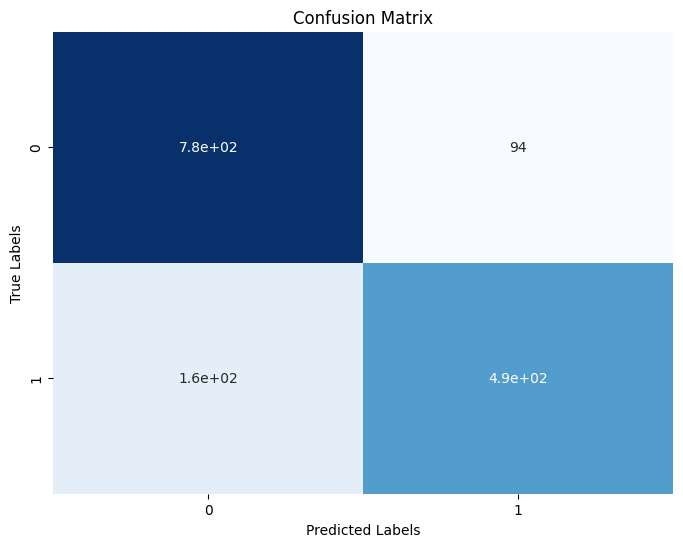

In [38]:
# Compute scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {accuracy:.2f}')
precision = precision_score(y_val, y_pred_val)
print(f'Precision: {precision:.2f}')
recall = recall_score(y_val, y_pred_val)
print(f'Recall: {recall:.2f}')
f1 = f1_score(y_val, y_pred_val)
print(f'F1-Score: {f1:.2f}')

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [39]:
# Predict test
predictions = trainer.predict(test_dataset)

# Extract array and get labels
predictions_array = predictions.predictions
y_pred_test = np.argmax(predictions_array, axis=1)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Put into df
submission_df = pd.DataFrame({"id": test_ids, "target":y_pred_test})
display(submission_df.head(1))

# Save
submission_df.to_csv(f"{SUBMISSION_PATH}modernBERT.csv",index=False)

,id,target
0,0,1
